# **Partie 1 : Mise en place de l'environnement de travail**

Dans cette partie nous allons faire le point sur la mise en place de l'environnement de travail en installant "spark et ses différentes composantes".

In [1]:
!pip install pyspark

In [2]:
!pip install scikit-learn

In [3]:
import matplotlib.pyplot as plt
import sklearn 
import numpy as np
import seaborn as sns 
import pandas as pd
import pyspark

In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

**Création de sparkContext**

In [5]:
spark = SparkSession.builder.master("local[2]").appName("Clustering with k-means method").getOrCreate()

In [6]:
spark

In [7]:
s_cont = spark.sparkContext
s_cont

<SparkContext master=local[2] appName=Clustering with k-means method>

# **Partie 2 : Données**

passons à la génération des données " 2 datasets de 3 différents types".

*Question 1 : génération des données*

In [8]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers= 2, n_features=2, random_state=0)

In [9]:
data = pd.DataFrame(data = X,columns=["var1","var2"])
data["y"]=y

In [10]:
data.head()

,var1,var2,y
0,0.466618,3.865713,0
1,2.843828,3.326509,0
2,0.611215,2.512460,0
3,3.816534,1.651759,1
4,1.280972,0.628274,1


*génération du RDD*

In [11]:
data_rdd = s_cont.parallelize(zip(X[:,0],X[:,1],y))

In [12]:
from pyspark.sql import Row
df_rdd = data_rdd.map(lambda c: Row(Var1=float(c[0]), Var2=float(c[1]), label=int(c[2])))

In [13]:
df = df_rdd.toDF()

In [14]:
df.show()

+--------------------+--------------------+-----+
|                Var1|                Var2|label|
+--------------------+--------------------+-----+
| 0.46661789679484156|  3.8657130258372034|    0|
|  2.8438280686964625|   3.326509447571979|    0|
|  0.6112148620002373|   2.512459779407206|    0|
|   3.816533648852741|  1.6517593235941797|    1|
|  1.2809724409460734|  0.6282738814866966|    1|
|  0.9885020621853124|  5.8730469419842946|    0|
|  1.0509448092182645|-0.10052806829392724|    1|
|  0.9146436764508477|   4.196482051157215|    0|
|  0.8778175541210628|  3.6403090410862826|    0|
|  0.9133661022290314| -0.4133067105032755|    1|
|  0.8903393115748823|   4.498080265494162|    0|
|  3.0943639618112706|  1.3767588840361653|    1|
|  1.2824956384546757|  1.7797202593009476|    1|
|   2.614566502823762|-0.16603193108761105|    1|
| -0.9694330046174637|   3.391003833313098|    0|
|-0.07228288652059756|   2.883769390269415|    0|
|   4.506497240507954|  0.6864576763064169|    1|


*question D : Le nouveau parametrage* : dans cette étape nous allons changer les paramètres de la genération des données

In [15]:
X_nv, y_nv = make_blobs(n_samples=10000, centers= 3, n_features=4, random_state=0)
data_nv = pd.DataFrame(data = X_nv,columns=["var1","var2","var3","var4"])
data_nv["y"]=y_nv
data_rdd_nv = s_cont.parallelize(zip(X_nv[:,0],X_nv[:,1],X_nv[:,2],X_nv[:,3],y_nv))
df_nv = data_rdd_nv.map(lambda c: Row(var1=float(c[0]), var2=float(c[1]),var3=float(c[2]), var4=float(c[3]), y=int(c[4]))).toDF()
df_nv.show()

+--------------------+-------------------+--------------------+--------------------+---+
|                var1|               var2|                var3|                var4|  y|
+--------------------+-------------------+--------------------+--------------------+---+
|  0.6581214348347171|  3.330950208806035| -3.1915145399441256|    8.99670908680436|  1|
|   2.201357680941256|  2.638305471651551|  2.8011225663376274|  1.0743820468193288|  0|
|  2.1141737865997605| 3.8081873285890175|   2.728857401172996|    1.01339259660899|  0|
|  0.8502711116492576| 3.9081446043865014|  2.6283803113546913| 0.15629458427565868|  0|
|   -2.34110797337813| 4.4072873906336385| -0.5634404916797624|   7.167195851675335|  1|
|  1.4927888618190013|  4.465759181979671|  3.9695437384544654|     1.5828726378719|  0|
|    9.20856981890792| -2.224851678200011|   5.055311128007941|  1.8971986484032808|  2|
|  0.5292787812679975|  6.373262719119204|  1.1158432028169358|-0.15446050710021608|  0|
|-0.11940115042601729

In [16]:
type(df_nv)

pyspark.sql.dataframe.DataFrame

**Commentaire** </br>
Dans cette partie nous avons généré deux types de datasets, le premier " nombre de variables 2, classe binaire " le nombre de clusters 2 et le nombre d'individu est de 1000.
Pour le deuxieme " nombre de variables 4, nombre de classes 3 et le nombre d'individu est de 10000.</br>
Dans la prochaien étape nous allons utiliser le deuxième dataset Pour faire notre analyse descriptive.

# **Partie 3 :Analyse descriptive**

In [17]:
def correlation(df,x_size=5,y_size=5):
    correl = df.corr(method = 'pearson')
    sns.set(rc={'figure.facecolor':'white'})
    fig, ax = plt.subplots(figsize=(x_size,y_size)) 
    correl_final = sns.heatmap(correl, vmin = -1, vmax = 1, center = 0, cmap = "RdBu_r", square = True, ax=ax)
    correl_final.set_title('Correlation', fontsize = 25, loc = 'left')
    return round(correl,2)

In [18]:
df_pd = df_nv.toPandas()
df_pd

,var1,var2,var3,var4,y
0,0.658121,3.330950,-3.191515,8.996709,1
1,2.201358,2.638305,2.801123,1.074382,0
2,2.114174,3.808187,2.728857,1.013393,0
3,0.850271,3.908145,2.628380,0.156295,0
4,-2.341108,4.407287,-0.563440,7.167196,1
...,...,...,...,...,...
9995,1.355846,4.955717,2.407268,0.413925,0
9996,9.037265,-3.254946,5.823505,-1.411962,2
9997,-1.686352,2.035441,-0.868777,8.843992,1
9998,-1.945826,2.620920,-1.720677,7.543392,1


In [19]:
#vérification du nombre de classes : 
df_nv.groupBy('y').count().show()

+---+-----+
|  y|count|
+---+-----+
|  0| 3334|
|  1| 3333|
|  2| 3333|
+---+-----+



AxesSubplot(0.125,0.125;0.775x0.755)


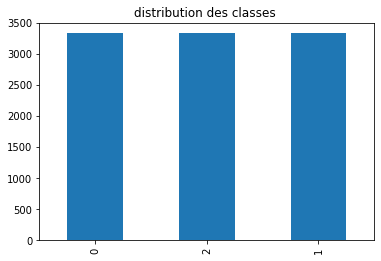

In [20]:

print(df_pd['y'].value_counts().plot(kind = 'bar',title = 'distribution des classes '))

In [21]:
#Describe du dataframe 
df_nv.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|              var1|              var2|              var3|              var4|                 y|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             10000|             10000|             10000|             10000|             10000|
|   mean|2.9030428968299193|1.6262767143171584|2.2020675130790908|3.1073537965856106|            0.9999|
| stddev|   4.7125802344158|3.0316801434818212| 3.073757112403275|3.5028826880181483|0.8165578158750719|
|    min|  -5.9735362545812|-5.974463939371841|-4.519159445017838|-3.003147473741441|                 0|
|    max|13.077099249044569| 7.683327455400309|  9.34372381743226|11.471561715895099|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



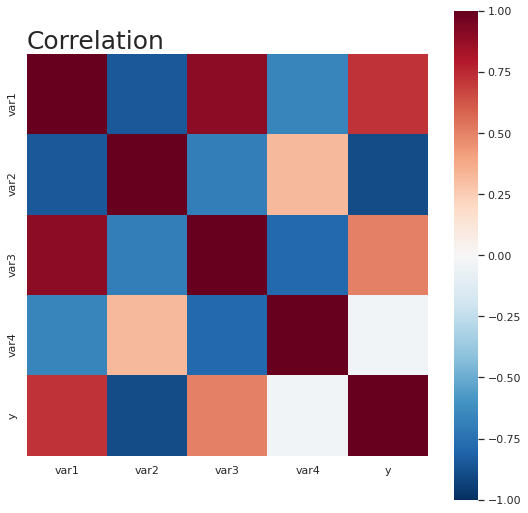

In [22]:
#correlation : 
corr = correlation(df_pd,9,9)

In [23]:
df_pd.describe()

,var1,var2,var3,var4,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.903043,1.626277,2.202068,3.107354,0.999900
std,4.712580,3.031680,3.073757,3.502883,0.816558
min,-5.973536,-5.974464,-4.519159,-3.003147,0.000000
25%,-0.929673,-1.666489,-0.579655,0.423371,0.000000
50%,0.978484,2.800840,2.020987,1.433093,1.000000
75%,8.576993,3.998547,5.176280,7.196846,2.000000
max,13.077099,7.683327,9.343724,11.471562,2.000000


In [24]:
# la variances des classes : 
# pour faciliter cette tache, on transforme notre ROW element en Pandas dataframe et on applique l'aggregation suivante

df_nv.toPandas().groupby("y").agg('var')

,var1,var2,var3,var4
y,,,,
0,0.989301,0.972445,0.993508,0.980659
1,0.967669,0.973861,1.012933,0.957460
2,1.006423,1.008627,1.026715,1.030712


# **Clustering avec des implémentations disponibles**

In [25]:
from  sklearn.metrics import normalized_mutual_info_score as NMI_score
def NMI(y, labels):
  print("NMI SCORE est :",round(NMI_score(y, labels), 2) * 100, "%")

### with scikit-learn

In [26]:
#Implémentation du k-means en utilisant scikit-learn : 
import time
from sklearn.cluster import KMeans
y_1 = df_pd.iloc[:,4]
df_pd = df_pd.drop(columns = "y")
df_pd

,var1,var2,var3,var4
0,0.658121,3.330950,-3.191515,8.996709
1,2.201358,2.638305,2.801123,1.074382
2,2.114174,3.808187,2.728857,1.013393
3,0.850271,3.908145,2.628380,0.156295
4,-2.341108,4.407287,-0.563440,7.167196
...,...,...,...,...
9995,1.355846,4.955717,2.407268,0.413925
9996,9.037265,-3.254946,5.823505,-1.411962
9997,-1.686352,2.035441,-0.868777,8.843992
9998,-1.945826,2.620920,-1.720677,7.543392


In [27]:
%%time
k_means1 = KMeans(n_clusters=3, random_state=42).fit(df_pd)


CPU times: user 84.4 ms, sys: 59.8 ms, total: 144 ms
Wall time: 144 ms


### with spark " dataframe"

In [28]:
from pyspark.ml.clustering import KMeans as KMeans_spark
from pyspark.ml.feature import VectorAssembler
 
#kmeans with pyspark " dataframe"
vect = VectorAssembler(inputCols=["var1","var2","var3","var4"],outputCol="out_put")
data_k = vect.transform(df_nv.drop("y"))

In [29]:
type(data_k)

pyspark.sql.dataframe.DataFrame

In [30]:
%%time
kmeans_spark = KMeans_spark(featuresCol="out_put",k=3,maxIter=100)
model = kmeans_spark.fit(data_k)

CPU times: user 76.8 ms, sys: 9.97 ms, total: 86.8 ms
Wall time: 6.01 s


### with spark RDD

In [31]:
# kmeans with pyspark "RDD"
#API BASE SUR RDD
from pyspark.mllib.clustering import KMeans

In [32]:
%%time
data_kr = df_nv.select('var1', 'var2','var3', 'var4').rdd.map(lambda t: (t[0], t[1],t[2], t[3]))
clusters = KMeans.train(data_kr, 3, maxIterations=100, initializationMode="random")

CPU times: user 27.7 ms, sys: 886 µs, total: 28.6 ms
Wall time: 1.94 s


In [33]:

NMI(y_1, k_means1.labels_)

NMI SCORE est : 100.0 %


In [34]:
#NMI  avec kmeans sckit-learn
prediction = model.transform(data_k).select('prediction').collect()
labels = [p.prediction for p in prediction ]

In [35]:
NMI(y_1,labels)

NMI SCORE est : 100.0 %


# **Implémentation du K-Means**

### Cas Unidimensionnel 

In [36]:
def compute_centroids(points,cluster_ids):
  # ( Id_Cluster, Sum of element in that cluster ) 
  sum_by_cluster = cluster_ids.zip(points).groupByKey().mapValues(sum)

  # (Id_Cluster, Number of occurence)
  count_by_cluster_id = cluster_ids.zip(points).groupByKey().mapValues(len)

  # ( Id_Cluster, Mean):
  return count_by_cluster_id.join(sum_by_cluster).map(lambda x : (x[0],x[1][1]/x[1][0])).sortByKey()

In [37]:
import numpy as np
def squared_distances(point, centroids):
  return np.sqrt(np.power(centroids-point,2))

In [38]:
def assign_clusters(points, centroids):
  list_centr = np.array(centroids.map(lambda x: x[1]).collect())
  return points.map(lambda x : np.argmin(squared_distances(x,list_centr)))

In [39]:
def Kmeans_Uni(points,k):
  centroids = np.array(points.collect()[0:k])
  labels = points.map(lambda x : np.argmin(squared_distances(x,centroids))).collect()
  new_list_id_clusters = []
  #1st itiration:  
  centroids = compute_centroids(points,s_cont.parallelize(labels))
  new_cluster_ids = assign_clusters(points, centroids).collect()
  #The stop condition:
  while(not np.array_equal(new_cluster_ids,labels) ):
    
    labels = new_cluster_ids
    centroids = compute_centroids(points,s_cont.parallelize(labels))
    new_cluster_ids = assign_clusters(points, centroids).collect()
  
  return labels,centroids

### Le cas multidimensionnel

In [40]:
def calculate_sum(X):
  sum = np.zeros(len(X[0]))
  for elm in X:
    sum = np.add(sum,elm)
  return sum.astype(int)



def compute_centroids_multidimensionnel(points,cluster_ids):
  # ( Id_Cluster, Sum of element in that cluster ) 
  sum_by_cluster = cluster_ids.zip(points).groupByKey().map(lambda x : (x[0], list(x[1]))).mapValues(calculate_sum)

  # (Id_Cluster, Number of occurence)
  count_by_cluster_id = cluster_ids.zip(points).groupByKey().mapValues(len)

  # ( Id_Cluster, Mean):
  return count_by_cluster_id.join(sum_by_cluster).map(lambda x : (x[0],x[1][1]/x[1][0])).sortByKey()




def assign_clusters_multidimensionnel(points, centroids):
  list_centr = np.array(centroids.map(lambda x: x[1]).collect())
  return points.map(lambda x : np.argmin(squared_distances_multiple(np.array(x),list_centr)))

def squared_distances_multiple(point, centroids):
    return np.sqrt(np.sum(np.power(centroids-point,2),axis=1))
  


  

In [41]:
def Kmeans_Mult(points,k):
  deb = np.random.randint(len(points.collect())-k)
  centroids = np.array(points.collect()[deb:deb+k])
  labels = points.map(lambda x : np.argmin(squared_distances_multiple(x,centroids))).collect()
  new_list_id_clusters = []
  
  #1st itiration:  
  centroids = compute_centroids_multidimensionnel(points,s_cont.parallelize(labels))
  new_cluster_ids = assign_clusters_multidimensionnel(points, centroids).collect()
  #The stop condition:
  while(not np.array_equal(new_cluster_ids,labels) ):
    
    labels = new_cluster_ids
    centroids = compute_centroids_multidimensionnel(points,s_cont.parallelize(labels))
    new_cluster_ids = assign_clusters_multidimensionnel(points, centroids).collect()
  
  return labels,centroids

### Tester le cas unidimensionnel

In [42]:
# Tester sur un exemple aléatoire

points_1 = s_cont.parallelize([1,-20,20,0,-1,-15,30,-12])
labels_1, centroids_1 =Kmeans_Uni(points_1,3)

In [43]:
labels_1

[0, 1, 2, 0, 0, 1, 2, 1]

In [44]:
centroids_1.collect()

[(0, 0.0), (1, -15.666666666666666), (2, 25.0)]

In [45]:
# Tester sur des nouvelles données générés avec make blobs ( on aura 10000 observations, 1 variable, et 5 clusters)

X2, y2 = make_blobs(n_samples=10000, centers=5, n_features=1,random_state=0)

points_2 = s_cont.parallelize(X2)

labels_2, centroids =Kmeans_Uni(points_2,5)
NMI(y2, labels_2)

NMI SCORE est : 42.0 %


In [46]:
# Tester sur des nouvelles données générés avec make blobs ( on aura 10000 observations, 1 variable, et 3 clusters)

X3, y3 = make_blobs(n_samples=10000, centers=3, n_features=1,random_state=0)

points_3 = s_cont.parallelize(X3)

labels_3, centroids =Kmeans_Uni(points_3,3)

NMI(y3, labels_3)

NMI SCORE est : 39.0 %


In [47]:
# Tester sur des nouvelles données générés avec make blobs ( on aura 500 observations, 1 variable, et 3 clusters)

X4, y4 = make_blobs(n_samples=500, centers=3, n_features=1,random_state=0)

points_4 = s_cont.parallelize(X4)

labels_4, centroids =Kmeans_Uni(points_4,3)

NMI(y4, labels_4)

NMI SCORE est : 38.0 %


### Test le cas multidimensionnel

In [48]:
# dans ce cas nous avons utilisé les données généré pour l'étude du k_means " dans la précédente partie".
points_13 = s_cont.parallelize(X_nv)
labels_13, centroids =Kmeans_Mult(points_13,3)

NMI(y_nv, labels_13)

NMI SCORE est : 100.0 %
